<a href="https://colab.research.google.com/github/astro-blue/Data-analysis-in-astronomy-2022/blob/main/week_14/Neural_network_Galaxy_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"

Mounted at /content/gdrive


In [2]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt

### You can find the data at https://drive.google.com/file/d/1hpDKSielsWGzuSwKI2M-mNzctK-2LF_w/view?usp=sharing

In [3]:
data = pf.open(root_dir+'Combined_DES_images_catalog.fits')
'''
Imaging dataset provided by Ting-Yun Cheng 
DES image dataset 
'''

image = np.copy(data[0].data)
for i in range(0,len(image)):
    small = image[i]
    search = np.where(small<=0)
    search_2 = np.where(small>0)
    small[search] = np.min(small[search_2])
    image[i]=small

flat_image = np.log10(image.reshape(2862,2500))
origin_image = image.reshape(2862,2500)
#flat_image = image.reshape(2862,2500)
labels = data[1].data['spiral']

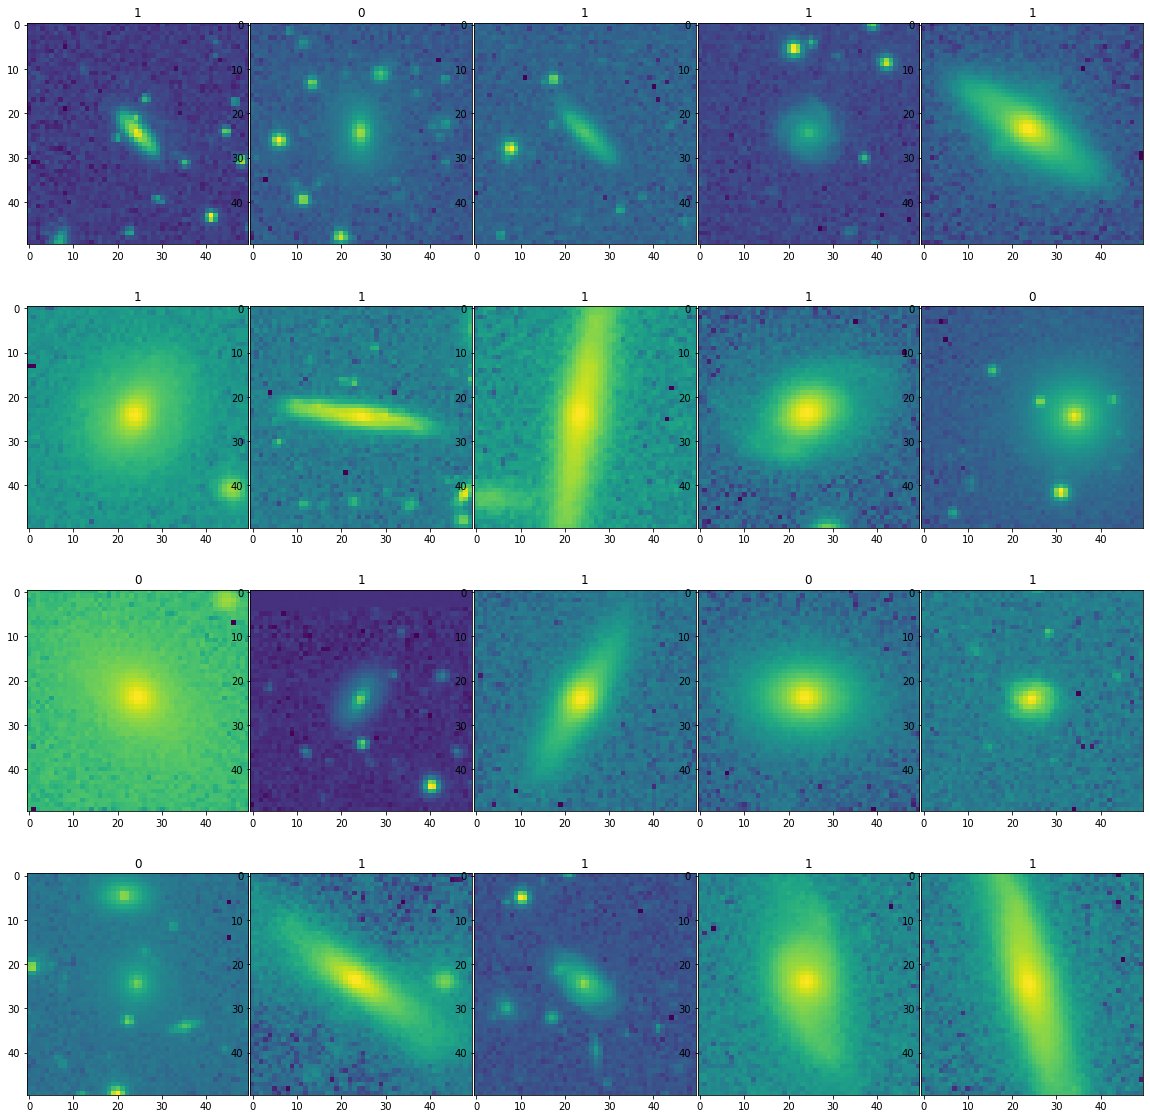

In [4]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.01)
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.imshow(flat_image[i].reshape(50,50))
    plt.title(labels[i])

In [177]:
import torch
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class fully_connected_NN(torch.nn.Module):
    def __init__(self):
        super(fully_connected_NN, self).__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(2500, 5000),
            torch.nn.BatchNorm1d(5000),
            torch.nn.ReLU())                    
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(5000, 2),
            )
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        out = x
        return out

cuda


In [178]:
'''This block is to organize data into Pytorch form'''

image_all = torch.from_numpy(np.array(origin_image,dtype=np.float32))
image_labels_all = np.zeros((len(labels),2))
for i in range(0,len(image_labels_all)):
    image_labels_all[i,labels[i]]=1

image_labels_all = torch.from_numpy(image_labels_all)

'''Using 0-2300 as the training set'''
image_train = image_all[0:2300].to(device)
image_labels = image_labels_all[0:2300,:].to(device)

'''Using 2300-2862 as the test set'''
test_labels = image_labels_all[2300:].to(device)
image_test = image_all[2300:,:].to(device)

In [179]:
model = fully_connected_NN().to(device)

In [180]:
learningRate = 0.01
epochs = 500
criterion = torch.nn.CrossEntropyLoss()
# Just the loss function : here we use the default CrossEntropy()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [181]:
accuracy_array = []
accuracy_test_array = []
loss_array = []
loss_test_array = []
epoch_array = []
batch_size = 64
N_total_train = len(image_labels)
for epoch in range(epochs):
   
    for start_index_batch in range(0,N_total_train,batch_size):
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        end_index = min(start_index_batch + batch_size, N_total_train)
        # get output from the model, given the inputs
        outputs = model(image_train[start_index_batch:end_index,:])
        
        # get loss for the predicted output
        loss = criterion(outputs, image_labels[start_index_batch:end_index,:])
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs_all = model(image_train)
        pred_y = torch.max(outputs_all, 1)[1].cpu().data.squeeze()
        accuracy = torch.sum((pred_y == torch.max(image_labels, 1)[1].cpu().data.squeeze()) / pred_y.size(0))
        #if epoch % 50 ==0:
        #    print(epoch,accuracy,loss)

        epoch_array.append(epoch)

        loss_array.append(float(loss.cpu().detach().numpy()))
        accuracy_array.append(float(accuracy.numpy()))


        outputs_test = model(image_test) 
        loss_test = criterion(outputs_test, test_labels)

        pred_y_test = torch.max(outputs_test, 1)[1].cpu().data.squeeze()
        accuracy_test = torch.sum((pred_y_test == torch.max(test_labels, 1)[1].cpu().data.squeeze()) / pred_y_test.size(0))
        accuracy_test_array.append(float(accuracy_test.numpy()))
        loss_test_array.append(float(loss_test.cpu().detach().numpy()))

    if epoch % 50 ==0:
        print(epoch,accuracy.numpy(),loss.cpu().detach().numpy(), accuracy_test.numpy(),loss_test.cpu().detach().numpy())


0 0.6656522 0.5216097547824954 0.62811387 0.6373829679742614
50 0.88739145 0.26272555202582265 0.8202846 0.37660483610497214
100 0.94478285 0.15528347342419502 0.8345195 0.3853343266263202
150 0.95521754 0.11517283048173871 0.8398576 0.41643687588433237
200 0.9595654 0.09634155265617228 0.84163696 0.44642538289264216
250 0.9621742 0.08416680310991917 0.8434163 0.4718928482293962
300 0.9652176 0.07466530091865675 0.83807814 0.4936198596054922
350 0.9686958 0.06683697229772344 0.8362988 0.5130113196002437
400 0.97391325 0.060030922911710145 0.8362988 0.5298015235646882
450 0.9769567 0.054207500304021515 0.8345195 0.5465194380407458


In [171]:
#outputs_test

(0.7, 1.0)

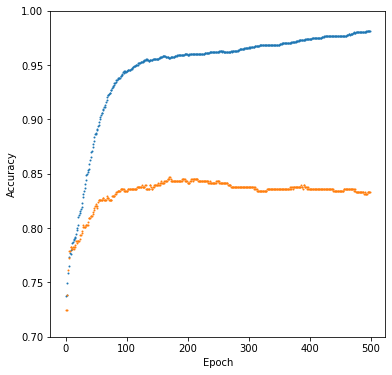

In [182]:
  # move the computation in GPU
plt.figure(figsize=(6,6))
plt.scatter(epoch_array,accuracy_array,s=1)
plt.scatter(epoch_array,accuracy_test_array,s=1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7,1)

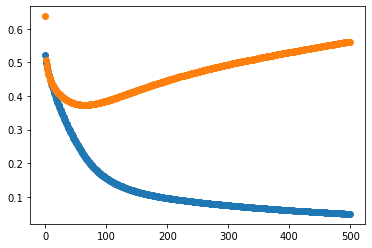

In [183]:
plt.scatter(epoch_array,loss_array)
plt.scatter(epoch_array,loss_test_array)

### Exercise one: Try to build a better model to obtain a better accuracy

Note that I encountered some problems which are not fully resolved. 
https://discuss.pytorch.org/t/performance-highly-degraded-when-eval-is-activated-in-the-test-phase/3323/65